In [1]:
a=1
b=2
a+b

3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
!pip install yfinance

In [4]:
import yfinance as yf
df = yf.download("TataMotors.NS", period="6mo", interval="1d",auto_adjust="True")
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS
Date,,,,,
2025-06-17,674.750000,686.150024,672.000000,686.099976,17112867
2025-06-18,670.250000,679.349976,668.000000,671.849976,12556088
2025-06-19,672.299988,676.299988,666.650024,670.250000,10895470
2025-06-20,676.200012,678.799988,670.099976,673.400024,11393470
2025-06-23,671.250000,676.000000,666.099976,670.000000,10265601


In [5]:
print(df.columns)

MultiIndex([( 'Close', 'TATAMOTORS.NS'),
            (  'High', 'TATAMOTORS.NS'),
            (   'Low', 'TATAMOTORS.NS'),
            (  'Open', 'TATAMOTORS.NS'),
            ('Volume', 'TATAMOTORS.NS')],
           names=['Price', 'Ticker'])


In [6]:
import numpy as np

df['body'] = (df['Close'] - df['Open']).abs()
df['upper_wick'] = df['High'] - np.maximum(df['Open'], df['Close'])
df['lower_wick'] = np.minimum(df['Open'], df['Close']) - df['Low']


In [7]:
df['hammer'] = (
    (df['lower_wick'] >= 2 * df['body']) &
    (df['upper_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0)
)


In [25]:
df[df['hammer']].tail()


Price,Close,High,Low,Open,Volume,body,upper_wick,lower_wick,hammer,range,ema20,uptrend,downtrend,hanging_man,shooting_star,hammer_marker,hanging_man_marker,shooting_star_marker
Date,,,,,,,,,,,,,,,,,,
2025-10-09,681.099976,685.0,668.799988,684.599976,16202851,3.5,0.400024,12.299988,True,16.200012,694.092125,False,True,False,False,665.455988,NaN,NaN


In [9]:
import numpy as np

df['body'] = (df['Close'] - df['Open']).abs()
df['upper_wick'] = df['High'] - np.maximum(df['Open'], df['Close'])
df['lower_wick'] = np.minimum(df['Open'], df['Close']) - df['Low']
df['range'] = df['High'] - df['Low']


In [10]:
df.columns = df.columns.get_level_values(0)


In [11]:
df['ema20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['uptrend'] = df['Close'] > df['ema20']
df['downtrend'] = df['Close'] < df['ema20']

In [12]:
df['ema20'] = df['Close'].ewm(span=20, adjust=False).mean()

df['uptrend'] = df['Close'] > df['ema20']
df['downtrend'] = df['Close'] < df['ema20']


In [13]:
df['hammer'] = (
    (df['lower_wick'] >= 2 * df['body']) &
    (df['upper_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0) &
    (df['downtrend'])
)


In [14]:
df['hanging_man'] = (
    (df['lower_wick'] >= 2 * df['body']) &
    (df['upper_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0) &
    (df['uptrend'])
)


In [15]:
df['shooting_star'] = (
    (df['upper_wick'] >= 2 * df['body']) &
    (df['lower_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0) &
    (df['uptrend'])
)


In [24]:
df[['hammer','hanging_man','shooting_star']].sum()


Price
hammer           1
hanging_man      0
shooting_star    0
dtype: int64

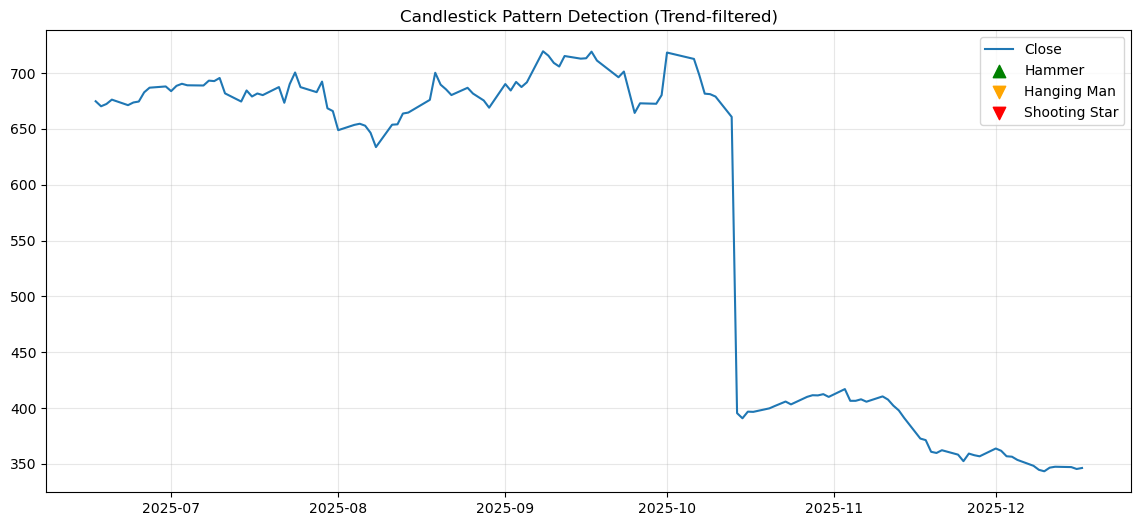

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close', linewidth=1.5)

plt.scatter(
    df.index[df['hammer']],
    df['Close'][df['hammer']],
    color='green',
    marker='^',
    s=80,
    label='Hammer'
)

plt.scatter(
    df.index[df['hanging_man']],
    df['Close'][df['hanging_man']],
    color='orange',
    marker='v',
    s=80,
    label='Hanging Man'
)

plt.scatter(
    df.index[df['shooting_star']],
    df['Close'][df['shooting_star']],
    color='red',
    marker='v',
    s=80,
    label='Shooting Star'
)

plt.title("Candlestick Pattern Detection (Trend-filtered)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [18]:
!pip install mplfinance


In [19]:
import mplfinance as mpf

df_plot = df.copy()
df_plot.index = pd.to_datetime(df_plot.index)


In [20]:
df_plot['hammer_plot'] = df_plot['Low'] * 0.995
df_plot['shooting_star_plot'] = df_plot['High'] * 1.005

df_plot.loc[~df_plot['hammer'], 'hammer_plot'] = np.nan
df_plot.loc[~df_plot['shooting_star'], 'shooting_star_plot'] = np.nan


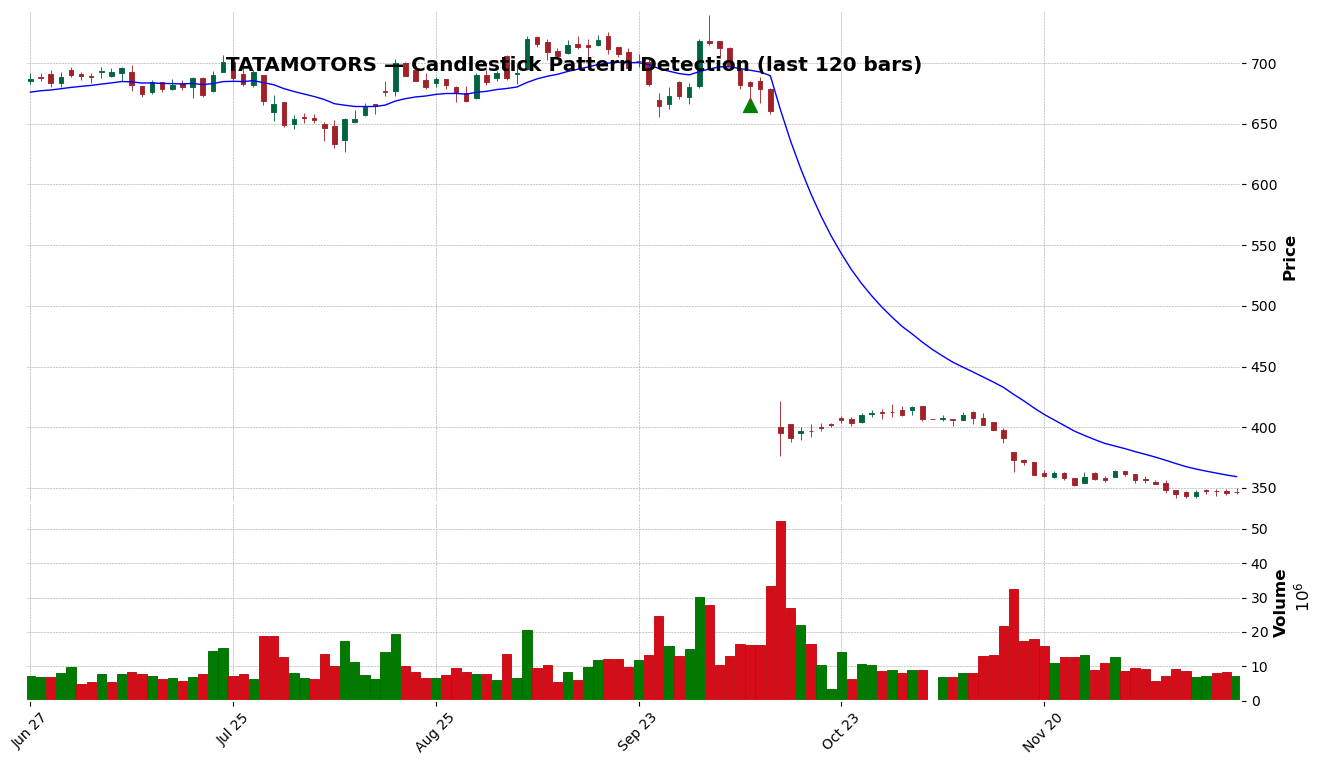

In [23]:
# Robust mplfinance candlestick plot with pattern markers (no ValueError)
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

# --- assume df exists (downloaded via yfinance) ---
# Example: df = yf.download("TATAMOTORS.NS", period="12mo", interval="1d", auto_adjust=True)

# 1) Flatten MultiIndex columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 2) Ensure datetime index
if not isinstance(df.index, pd.DatetimeIndex):
    # If df has a 'Date' or 'datetime' column, use it; otherwise try to convert index
    try:
        df.index = pd.to_datetime(df.index)
    except Exception:
        # try a common column name:
        if 'datetime' in df.columns:
            df.index = pd.to_datetime(df['datetime'])
            df.drop(columns=['datetime'], inplace=True)
        elif 'Date' in df.columns:
            df.index = pd.to_datetime(df['Date'])
            df.drop(columns=['Date'], inplace=True)
        else:
            raise RuntimeError("Could not convert index to DatetimeIndex. Make sure df index or a column contains dates.")

# 3) Calculate EMA and candle anatomy
df['ema20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['body'] = (df['Close'] - df['Open']).abs()
df['upper_wick'] = df['High'] - np.maximum(df['Open'], df['Close'])
df['lower_wick'] = np.minimum(df['Open'], df['Close']) - df['Low']
df['range'] = df['High'] - df['Low']

# 4) Trend flags
df['uptrend'] = df['Close'] > df['ema20']
df['downtrend'] = df['Close'] < df['ema20']

# 5) Pattern detection (trend-filtered)
df['hammer'] = (
    (df['lower_wick'] >= 2 * df['body']) &
    (df['upper_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0) &
    (df['downtrend'])
)
df['hanging_man'] = (
    (df['lower_wick'] >= 2 * df['body']) &
    (df['upper_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0) &
    (df['uptrend'])
)
df['shooting_star'] = (
    (df['upper_wick'] >= 2 * df['body']) &
    (df['lower_wick'] <= 0.3 * df['body']) &
    (df['body'] > 0) &
    (df['uptrend'])
)

# 6) Create marker series used for plotting. Place marker slightly above/below wicks.
df['hammer_marker'] = np.where(df['hammer'], df['Low'] * 0.995, np.nan)
df['hanging_man_marker'] = np.where(df['hanging_man'], df['High'] * 1.005, np.nan)
df['shooting_star_marker'] = np.where(df['shooting_star'], df['High'] * 1.005, np.nan)

# 7) OPTIONAL: zoom into last N candles for clarity (choose N)
N = 120   # last ~120 trading days; change as needed
df_plot = df.copy().iloc[-N:]

# 8) Build addplot list but only add series that have at least one finite value
apds = []

# EMA is usually present
apds.append(mpf.make_addplot(df_plot['ema20'], color='blue', width=1))

# helper to add marker only if there is at least one non-NaN
def add_marker_if_exists(col_series, marker, color, ms=120):
    if col_series.notna().any():
        apds.append(
            mpf.make_addplot(
                col_series,
                type='scatter',
                marker=marker,
                markersize=ms,
                color=color
            )
        )

add_marker_if_exists(df_plot['hammer_marker'], marker='^', color='green', ms=100)
add_marker_if_exists(df_plot['hanging_man_marker'], marker='v', color='orange', ms=100)
add_marker_if_exists(df_plot['shooting_star_marker'], marker='v', color='red', ms=100)

# 9) Plot (candles + volume + addplots)
mpf.plot(
    df_plot,
    type='candle',
    style='charles',
    volume=True,
    addplot=apds,
    title='TATAMOTORS — Candlestick Pattern Detection (last {} bars)'.format(N),
    ylabel='Price',
    ylabel_lower='Volume',
    figsize=(14,8),
    tight_layout=True
)


In [ ]:
pip install jupyterlab-git